In [15]:
from einops.einops import rearrange
import torch
mask = torch.randn((2,3,4))
mask_v, all_j_ids = mask.max(dim=2)  # mask_v: [N,L]
print(mask_v.shape,all_j_ids.shape)
b_ids, i_ids = torch.where(mask_v) #i_ids : [N*L]
print(b_ids.shape,i_ids.shape)
j_ids = all_j_ids[b_ids, i_ids]
print(j_ids)

i_ids = torch.arange(0,5).long()
print(i_ids)

torch.Size([2, 3]) torch.Size([2, 3])
torch.Size([6]) torch.Size([6])
tensor([1, 3, 3, 2, 2, 2])
tensor([0, 1, 2, 3, 4])


In [17]:
from einops.einops import rearrange
import torch
from kornia.utils import create_meshgrid
N =2
point2d = torch.Tensor([[[11.,3.3],[1,2.2],[5.6,3.8]],[[6.6,5.3],[5.5,9.8],[1.4,11.1]]])
print(point2d.shape)

point2d = point2d.round().long()
b_x = torch.flatten(point2d[:,:,0])
b_y = torch.flatten(point2d[:,:,1])
print('b_x shape',b_x.shape)
b,xx = torch.where(point2d[:,:,0]>=0)
print(xx.dtype)
#
device = point2d.device
grid = torch.zeros(2,12,12,device=device)

# print(mask)
#
#
print(b,b_y,b_x)
grid[b,b_y,b_x] =1
print(grid)
# torch.where(point2d)
# print(point2d)


# i_ids = torch.index_select(point2d, dim = 1, index = torch.tensor([0]))
#
# print(i_ids)
# print('point2d')
# print(point2d)
# print(point2d.shape)

# print(grid.shape)
# grid[point2d]  =1
# print(grid)


# x2 = torch.Tensor([[ 0.,  1.,  2.],
#                    [ 5.,  6.,  7.],
#                    [10., 11., 12.],
#                    [10., 11., 12.]])
#
# mask1 = torch.LongTensor([1,2])
# mask2 = torch.LongTensor([2,2])
# print(x2.shape)
# print(mask1.shape)
# x2[mask1,mask2] = -1
# print(x2)





torch.Size([2, 3, 2])
b_x shape torch.Size([6])
torch.int64
tensor([0, 0, 0, 1, 1, 1]) tensor([ 3,  2,  4,  5, 10, 11]) tensor([11,  1,  6,  7,  6,  1])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0

In [1]:

import os
import numpy as np
import torch
x = torch.ones((2,1,2,3))
heatmap_nms_batch = torch.cumsum(x,2)
heatmap_nms_batch[::3] =0
print(heatmap_nms_batch)
pts_idx = heatmap_nms_batch[...].nonzero()  # [N, 4(batch, 0, y, x)]
# print(pts_idx)
y = torch.topk(heatmap_nms_batch,1,largest=True,sorted=True)
print(y)

tensor([[[[0., 0., 0.],
          [0., 0., 0.]]],


        [[[1., 1., 1.],
          [2., 2., 2.]]]])
torch.return_types.topk(
values=tensor([[[[0.],
          [0.]]],


        [[[1.],
          [2.]]]]),
indices=tensor([[[[0],
          [0]]],


        [[[0],
          [0]]]]))


In [72]:
import math
import torch
from torch import nn


class PositionEncodingSine(nn.Module):
    """
    This is a sinusoidal position encoding that generalized to 2-dimensional images
    """

    def __init__(self, d_model, max_shape=(512, 512), temp_bug_fix=True):
        """
        Args:
            max_shape (tuple): for 1/8 featmap, the max length of 256 corresponds to 2048 pixels
            temp_bug_fix (bool): As noted in this [issue](https://github.com/zju3dv/LoFTR/issues/41),
                the original implementation of LoFTR includes a bug in the pos-enc impl, which has little impact
                on the final performance. For now, we keep both impls for backward compatability.
                We will remove the buggy impl after re-training all variants of our released models.
        """
        super().__init__()

        pe = torch.zeros((d_model, *max_shape))
        y_position = torch.ones(max_shape).cumsum(0).float().unsqueeze(0)
        x_position = torch.ones(max_shape).cumsum(1).float().unsqueeze(0)

        if temp_bug_fix:
            div_term = torch.exp(torch.arange(0, d_model//2, 2).float() * (-math.log(10000.0) / (d_model//2)))
        else:  # a buggy implementation (for backward compatability only)
            div_term = torch.exp(torch.arange(0, d_model//2, 2).float() * (-math.log(10000.0) / d_model//2))
        div_term = div_term[:, None, None]  # [C//4, 1, 1]
        pe[0::4, :, :] = torch.sin(x_position * div_term)
        pe[1::4, :, :] = torch.cos(x_position * div_term)
        pe[2::4, :, :] = torch.sin(y_position * div_term)
        pe[3::4, :, :] = torch.cos(y_position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0), persistent=False)  # [1, C, H, W]

    def forward(self, x):
        """
        Args:
            x: [N, C, H, W]
        """
        return x + self.pe[:, :, :x.size(2), :x.size(3)]

class PositionEncodingSine_line(nn.Module):
    """
    This is a sinusoidal position encoding that generalized to 1-dimensional sequences
    """

    def __init__(self, d_model, temp_bug_fix=True):
        """
        Args:
            max_shape (tuple): for 1/8 featmap, the max length of 256 corresponds to 2048 pixels
            temp_bug_fix (bool): As noted in this [issue](https://github.com/zju3dv/LoFTR/issues/41),
                the original implementation of LoFTR includes a bug in the pos-enc impl, which has little impact
                on the final performance. For now, we keep both impls for backward compatability.
                We will remove the buggy impl after re-training all variants of our released models.
        """
        super().__init__()
        if temp_bug_fix:
            div_term = torch.exp(torch.arange(0, d_model//2, 2).float() * (-math.log(10000.0) / (d_model//2)))
        else:  # a buggy implementation (for backward compatability only)
            div_term = torch.exp(torch.arange(0, d_model//2, 2).float() * (-math.log(10000.0) / d_model//2))

        self.div_term = div_term[:,None, None]  # [C//4, 1]





    def forward(self, x, pts_int):
        """
        Args:
            x: [bs, C, L]
            pts_int:[bs,L,2]
        """
        d_model = x.shape[1]
        x_position = pts_int[:,:,0].unsqueeze(0)
        y_position = pts_int[:,:,1].unsqueeze(0)

        pe = torch.zeros((x.shape[0],d_model, x.shape[2]))
        print(pe.size())
        b = torch.sin(x_position * self.div_term).permute((1,0,2))
        print(b.size())
        pe[:,0::4, :] = torch.sin(x_position * self.div_term).permute((1,0,2))
        pe[:,1::4, :] = torch.cos(x_position * self.div_term).permute((1,0,2))
        pe[:,2::4, :] = torch.sin(y_position * self.div_term).permute((1,0,2))
        pe[:,3::4, :] = torch.cos(y_position * self.div_term).permute((1,0,2))
        return x + pe


model = PositionEncodingSine(16)
x = torch.zeros(1,16,2,2)
y = model(x)
print('y size',y.size())
# print(y)
model2 = PositionEncodingSine_line(16)
x = torch.zeros(2,16,4)

pts_int = torch.tensor([[[  0.,   0.],
         [  0.,   1.],
         [  1.,   0.],[  1.,   1.]],
               [[  1.,   1.],
         [  1.,   0.],
         [  1.,   1.],[  1.,   2.]]
                        ])
pts_int = pts_int +1

y = model2(x,pts_int)
print('y size',y.size())
print(y)





y size torch.Size([1, 16, 2, 2])
torch.Size([2, 16, 4])
torch.Size([2, 4, 4])
y size torch.Size([2, 16, 4])
tensor([[[ 0.8415,  0.8415,  0.9093,  0.9093],
         [ 0.5403,  0.5403, -0.4161, -0.4161],
         [ 0.8415,  0.9093,  0.8415,  0.9093],
         [ 0.5403, -0.4161,  0.5403, -0.4161],
         [ 0.0998,  0.0998,  0.1987,  0.1987],
         [ 0.9950,  0.9950,  0.9801,  0.9801],
         [ 0.0998,  0.1987,  0.0998,  0.1987],
         [ 0.9950,  0.9801,  0.9950,  0.9801],
         [ 0.0100,  0.0100,  0.0200,  0.0200],
         [ 0.9999,  0.9999,  0.9998,  0.9998],
         [ 0.0100,  0.0200,  0.0100,  0.0200],
         [ 0.9999,  0.9998,  0.9999,  0.9998],
         [ 0.0010,  0.0010,  0.0020,  0.0020],
         [ 1.0000,  1.0000,  1.0000,  1.0000],
         [ 0.0010,  0.0020,  0.0010,  0.0020],
         [ 1.0000,  1.0000,  1.0000,  1.0000]],

        [[ 0.9093,  0.9093,  0.9093,  0.9093],
         [-0.4161, -0.4161, -0.4161, -0.4161],
         [ 0.9093,  0.8415,  0.9093,  0.1411

In [63]:
import torch
import einops
data = torch.rand([2,2,2],dtype=torch.float)
print(data)


out = torch.nonzero(torch.gt(data,0.5))

print(out)
a = torch.rand(4)
b = torch.rand(4)
print(a)
c = torch.stack([a,b],dim=1)/(torch.tensor([10,0.1]))
print(c)

tensor([[[0.2752, 0.0548],
         [0.8540, 0.1985]],

        [[0.9737, 0.9222],
         [0.7755, 0.3945]]])
tensor([[0, 1, 0],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0]])
tensor([0.7573, 0.9013, 0.0987, 0.6150])
tensor([[0.0757, 9.0545],
        [0.0901, 6.0487],
        [0.0099, 8.7889],
        [0.0615, 7.1877]])


In [3]:
import torch
import cv2
import numpy as np
img = cv2.imread("/home/gzr/下载/chorme_download/LINEMOD/ape/JPEGImages/000000.jpg")


img_new = cv2.Canny(img,80,200)

cv2.imwrite('aa.jpg',img_new)



True

In [39]:
import torch
a = torch.randn((2,3,2))
b = torch.ones((2,2,2))
a = a[:,:,None,:]
b = b[:,None,:,:]
print(a.size())
print(b.size())
ab = a - b
ab = (ab[:,:,:,0]**2+ab[:,:,:,1]**2)**0.5
print(ab.size())
print(ab)

torch.Size([2, 3, 1, 2])
torch.Size([2, 1, 2, 2])
torch.Size([2, 3, 2])
tensor([[[2.4777, 2.4777],
         [1.6236, 1.6236],
         [1.7788, 1.7788]],

        [[1.6942, 1.6942],
         [1.7929, 1.7929],
         [1.8237, 1.8237]]])


In [91]:
class GeometryPositionEncodingSine(nn.Module):
    """
    This is a sinusoidal position encoding that generalized to 2-dimensional images
    """

    def __init__(self, d_model, temp_bug_fix=True):
        """
        Args:
            max_shape (tuple): for 1/8 featmap, the max length of 256 corresponds to 2048 pixels
            temp_bug_fix (bool): As noted in this [issue](https://github.com/zju3dv/LoFTR/issues/41),
                the original implementation of LoFTR includes a bug in the pos-enc impl, which has little impact
                on the final performance. For now, we keep both impls for backward compatability.
                We will remove the buggy impl after re-training all variants of our released models.
        """
        super().__init__()

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / (d_model)))
        self.div_term = div_term[None,:, None, None]  # [1,C//2, 1, 1]
        self.d_model = d_model
        print('dim_div shape',self.div_term.size())

    def forward(self, x):
        """
        Args:
            x: [N, L, S]
            return [N,C,L,S]
        """
        dis = x.unsqueeze(1)
        device = x.device
        pe = torch.zeros((x.shape[0],self.d_model, x.shape[1],x.shape[2]), device=device)
        pe[:,0::2, :, :] = torch.sin(dis * self.div_term)
        pe[:,1::2, :, :] = torch.cos(dis * self.div_term)
        return pe

geo = GeometryPositionEncodingSine(8)
dis = torch.randn((1,2,3))
print(dis)
out = geo(dis)
# print(out)
print(out.shape)

dim_div shape torch.Size([1, 4, 1, 1])
torch.Size([2, 4, 2])
torch.Size([2, 8, 4, 2])


In [27]:
import torch
kernelSize = 11
paddingSize = 4

data = torch.randn(size=[2,2,1])

print(data)
gridY = torch.arange(0, paddingSize ).view(1, 1, -1, 1).expand(1, 1,paddingSize, paddingSize).contiguous()
gridX = torch.arange(0, paddingSize).view(1, 1, 1, -1).expand(1, 1, paddingSize,  paddingSize).contiguous().reshape(1,1,-1)

print(gridX.shape)
print(gridX)
data  = data+gridX
print(data.shape)

# grid = torch.cat((gridX, gridY), dim=3)
# print(grid)
# print(gridX.shape)
# print('grid size:',grid.shape)



tensor([[[-0.3563],
         [-0.2508]],

        [[ 1.5626],
         [-0.6626]]])
torch.Size([1, 1, 16])
tensor([[[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]]])
torch.Size([2, 2, 16])


In [23]:
featSize = 11
gridY = torch.linspace(-1, 1, steps = featSize).view(1, -1, 1, 1).expand(1, featSize, featSize, 1)
gridX = torch.linspace(-1, 1, steps = featSize).view(1, 1, -1, 1).expand(1, featSize,  featSize, 1)
grid = torch.cat((gridX, gridY), dim=3)
grid = grid.view(1,-1,2)
print(grid.shape)
print(grid)

torch.Size([1, 121, 2])
tensor([[[-1.0000e+00, -1.0000e+00],
         [-8.0000e-01, -1.0000e+00],
         [-6.0000e-01, -1.0000e+00],
         [-4.0000e-01, -1.0000e+00],
         [-2.0000e-01, -1.0000e+00],
         [-1.4901e-08, -1.0000e+00],
         [ 2.0000e-01, -1.0000e+00],
         [ 4.0000e-01, -1.0000e+00],
         [ 6.0000e-01, -1.0000e+00],
         [ 8.0000e-01, -1.0000e+00],
         [ 1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -8.0000e-01],
         [-8.0000e-01, -8.0000e-01],
         [-6.0000e-01, -8.0000e-01],
         [-4.0000e-01, -8.0000e-01],
         [-2.0000e-01, -8.0000e-01],
         [-1.4901e-08, -8.0000e-01],
         [ 2.0000e-01, -8.0000e-01],
         [ 4.0000e-01, -8.0000e-01],
         [ 6.0000e-01, -8.0000e-01],
         [ 8.0000e-01, -8.0000e-01],
         [ 1.0000e+00, -8.0000e-01],
         [-1.0000e+00, -6.0000e-01],
         [-8.0000e-01, -6.0000e-01],
         [-6.0000e-01, -6.0000e-01],
         [-4.0000e-01, -6.0000e-01],
         [-2.0

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
from einops.einops import rearrange, repeat
data = torch.rand(1,1,4,8)
W = 5
stride = 2
print(data)
image0_unfold = F.unfold(data, kernel_size=(W, W), stride=stride, padding=W // 2)  # input: tensor数据，四维， Batchsize, channel, height, width
print(image0_unfold.shape)
print(image0_unfold)
# image0_unfold = rearrange(image0_unfold, 'n (c ww) l -> n l ww c', ww=W ** 2)
#
# image0_unfold = image0_unfold[[0,0],[0,1]].squeeze(-1) # L,ww
#
# mask_unfold = image0_unfold > 0
#
# b_ids, i_ids = torch.where(mask_unfold)
#
# x = i_ids % 3
# y = torch.div(i_ids, 3, rounding_mode='trunc')
#
# print(image0_unfold)
# index_nonzero =torch.argmax(image0_unfold, dim=1)
# print('index_non',index_nonzero)
# coords_x = (index_nonzero%3).reshape(-1,1)
# coords_y =  torch.div(index_nonzero, 3, rounding_mode='trunc').reshape(-1,1)
# coords = torch.cat((coords_x,coords_y),dim=-1)
# print(coords)

tensor([[[[0.6206, 0.1479, 0.7961, 0.2118, 0.0869, 0.6389, 0.0293, 0.7476],
          [0.3708, 0.4652, 0.8750, 0.7365, 0.8504, 0.1977, 0.3954, 0.8611],
          [0.8842, 0.3237, 0.0056, 0.3348, 0.0518, 0.5535, 0.8364, 0.6321],
          [0.3069, 0.6408, 0.4480, 0.9343, 0.2293, 0.3833, 0.6137, 0.6677]]]])
torch.Size([1, 25, 8])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6206, 0.7961, 0.0869],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1479, 0.2118, 0.6389],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.6206, 0.7961, 0.0869, 0.0293],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.1479, 0.2118, 0.6389, 0.7476],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7961, 0.0869, 0.0293, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3708, 0.8750, 0.8504],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4652, 0.7365, 0.1977],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.3708, 0.8750, 0.8504, 0.3954],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.4652, 0.7365, 0.1977, 0.86

2


TypeError: unsupported operand type(s) for <<: 'str' and 'int'

In [100]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, paired_distances

x = np.array([[1, 0, 1, 1, 1, 0],[0, 0, 1, 1, 1, 0],[0, 0, 1, 1, 1, 0]])
y = np.array([[0, 0, 1, 1, 1, 0],[0, 0, 1, 1, 1, 0],[0, 0, 1, 1, 1, 0]])
# 余弦相似度
simi = cosine_similarity(x, y)
print('cosine similarity:', simi)
# # 余弦距离 = 1 - 余弦相似度
# dist = paired_distances(x, y, metric='cosine')
# print('cosine distance:', dist)

cosine similarity: [[0.8660254 0.8660254 0.8660254]
 [1.        1.        1.       ]
 [1.        1.        1.       ]]


/home/gzr/anaconda3/envs/loftr/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


In [2]:
import torch
import torch.nn.functional as F
#假设feature1为N*C*W*H， feature2也为N*C*W*H（基本网络中的tensor都是这样）
feature1 = torch.tensor([0, 0, 1, 1, 0, 0,0., 1, 0, 0, 0, 0])#将特征转换为N*(C*W*H)，即两维
feature2 = torch.tensor([1, 1, 1, 1, 1, 0,0., 0, 0, 1, 0, 0])
#
# feature1 = F.normalize(feature1,p=2,dim=0)  #F.normalize只能处理两维的数据，L2归一化
# feature2 = F.normalize(feature2,p=2,dim=0)
print(feature1)
print(feature2)

dis = ((feature1-feature2)**2).sum(-1)/(feature2.shape[0])

print(dis)

a = torch.rand(2,3)


tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor(0.4167)


tensor([[[78.2036, 45.6120, 94.0905, 90.8038, 89.9274],
         [69.5287, 99.9690, 18.7903, 30.0074, 33.4260],
         [79.4677, 51.1680, 93.0087, 48.0694, 38.4967],
         [55.3696, 68.4633, 89.2155, 19.1479, 31.4294],
         [64.1098, 35.9677, 20.3331, 77.1543, 99.2718]]])


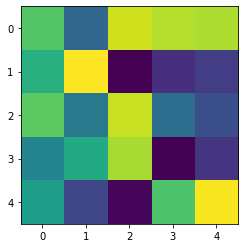

theta tensor([[ 1., -0., -1.],
        [ 0.,  1., -1.]])
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000, 78.2036, 45.6120, 94.0905],
          [ 0.0000,  0.0000, 69.5287, 99.9690, 18.7903],
          [ 0.0000,  0.0000, 79.4677, 51.1680, 93.0087]]]])


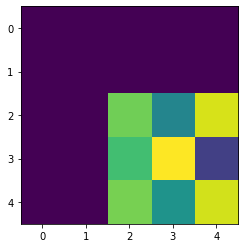

In [12]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
W = 5
H  = 5
img_torch = torch.rand(1,H,W) *100 # theta 的第三列为平移比例，向右为负，向下为负；
print(img_torch)
plt.imshow(img_torch.numpy().transpose(1,2,0))
plt.show()
angle = 0#* math.pi / 180
theta = torch.tensor([[np.cos(angle), -np.sin(angle),-1],
                  [np.sin(angle), np.cos(angle),-1]], dtype=torch.float)

print('theta',theta)

grid = F.affine_grid(theta.unsqueeze(0), img_torch.unsqueeze(0).size(),align_corners=True)

output = F.grid_sample(img_torch.unsqueeze(0), grid,align_corners=True)
print(output)
new_img_torch = output[0]
plt.imshow(new_img_torch.numpy().transpose(1,2,0))
plt.show()
# bs = 1
# theta = torch.cat((theta, torch.tensor([[0,0,1]])), dim=0).unsqueeze(0)  # [x,y]
# print(theta)
# T = torch.tensor([[[2 / W, 0, -1],
#                            [0, 2 / H, -1],
#                            [0, 0, 1]]])
# T_inv = torch.linalg.inv(T)
# T = T.repeat(bs, 1, 1)
# T_inv = T_inv.repeat(bs, 1, 1)
# M = torch.einsum('bij,bjk-> bik', T_inv, theta.inverse())
# M = torch.einsum('bij,bjk->bik', M, T)
# # M = M.inverse()
# # [0,0,1]
# P = torch.tensor([[[0], [0], [1.0]]])
#
# # print(P.shape)
# P1 = torch.einsum('bij,bjk->bik', M, P)
# print('P1:',P1)

# print(M)

In [103]:
import numpy as np
a = torch.rand(10,2)
print(a)
mask_x = a[:,0]<-0.5
mask_y = a[:,1]<0.5

mask = mask_x*mask_y
if mask.sum(0)==0:
    pass
else:
    a = a[mask]
print(a)

tensor([[0.0197, 0.8453],
        [0.0599, 0.9183],
        [0.7063, 0.0162],
        [0.1816, 0.3993],
        [0.3095, 0.7907],
        [0.9358, 0.1015],
        [0.3192, 0.1652],
        [0.8860, 0.8906],
        [0.9184, 0.4837],
        [0.2416, 0.8395]])
tensor([[0.0197, 0.8453],
        [0.0599, 0.9183],
        [0.7063, 0.0162],
        [0.1816, 0.3993],
        [0.3095, 0.7907],
        [0.9358, 0.1015],
        [0.3192, 0.1652],
        [0.8860, 0.8906],
        [0.9184, 0.4837],
        [0.2416, 0.8395]])


In [59]:
import torch
data = [[[10.,5],[8, 10],[10, 50]]] #
data2 = [[[18.,105],[16, 160],[18, 150]]] #
src_keypts = torch.tensor(data)
tgt_keypts = torch.tensor(data2)
sigma_spat = 100
src_dist = torch.norm((src_keypts[:, :, None, :] - src_keypts[:, None, :, :]), dim=-1)
corr_compatibility = src_dist - torch.norm((tgt_keypts[:, :, None, :] - tgt_keypts[:, None, :, :]),dim=-1)

print(corr_compatibility)
corr_compatibility = torch.clamp(1.0 - corr_compatibility ** 2 /sigma_spat ** 2, min=0)


print(src_dist.shape)

print(corr_compatibility)

tensor([[[  0.0000, -49.6512,   0.0000],
         [-49.6512,   0.0000,  29.8519],
         [  0.0000,  29.8519,   0.0000]]])
torch.Size([1, 3, 3])
tensor([[[1.0000, 0.7535, 1.0000],
         [0.7535, 1.0000, 0.9109],
         [1.0000, 0.9109, 1.0000]]])


In [120]:
import numpy as np
def integrate_trans(R, t):
    """
    Integrate SE2 transformations from R and t, support torch.Tensor and np.ndarry.
    Input
        - R: [2, 2] or [bs, 2, 3], rotation matrix
        - t: [2, 1] or [bs, 2, 1], translation matrix
    Output
        - trans: [3, 3] or [bs, 3, 3], SE2 transformation matrix
    """
    if len(R.shape) == 3: # batch
        if isinstance(R, torch.Tensor):
            trans = torch.eye(3)[None].repeat(R.shape[0], 1, 1).to(R.device)
        else:
            trans = np.eye(3)[None]
        trans[:, :2, :2] = R
        trans[:, :2, 2:3] = t.view([-1, 2, 1])
    else:
        if isinstance(R, torch.Tensor):
            trans = torch.eye(3).to(R.device)
        else:
            trans = np.eye(3)
        trans[:2, :2] = R
        trans[:2, 2:3] = t
    return trans

def rigid_transform_2d( A, B, weights=None, weight_threshold=0):
    """
    Input:
        - A:       [bs, num_corr, 2], source point cloud
        - B:       [bs, num_corr, 2], target point cloud
        - weights: [bs, num_corr]     weight for each correspondence
        - weight_threshold: float,    clips points with weight below threshold
    Output:
        - R, t
    """
    bs = A.shape[0]
    if weights is None:
        weights = torch.ones_like(A[:, :, 0])
    weights[weights < weight_threshold] = 0

     # find mean of point cloud
    centroid_A = torch.sum(A * weights[:, :, None], dim=1, keepdim=True) / (torch.sum(weights, dim=1, keepdim=True)[:, :, None] + 1e-6)
    centroid_B = torch.sum(B * weights[:, :, None], dim=1, keepdim=True) / (torch.sum(weights, dim=1, keepdim=True)[:, :, None] + 1e-6)
    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    # construct weight covariance matrix
    Weight = torch.diag_embed(weights)
    H = Am.permute(0, 2, 1) @ Weight @ Bm
    U, S, Vt = torch.svd(H.cpu())
    U, S, Vt = U.to(weights.device), S.to(weights.device), Vt.to(weights.device)


    delta_UV = torch.det(Vt @ U.permute(0, 2, 1))
    eye = torch.eye(2)[None, :, :].repeat(bs, 1, 1).to(A.device)
    eye[:, -1, -1] = delta_UV
    R = Vt @ eye @ U.permute(0, 2, 1)
    t = centroid_B.permute(0,2,1) - R @ centroid_A.permute(0,2,1)
    print('Estimated R:\n',R)
    print('Estimated T:\n',t)
    trans = integrate_trans(R,t)
    print(trans)


bs_src_point = np.array([[[1.,0],[2, 1],[3, 2],[1,1]]]) #
bs_src_point = bs_src_point[0].T
bs_src_point = bs_src_point[None]
theta = 30
theta = (theta/180.0)*np.pi
real_rot = np.array([ [np.cos(theta),-np.sin(theta)],
                      [np.sin(theta),np.cos(theta)]
])
real_t = np.array([10,20]).reshape(2,1)
bs_tgt_point = real_rot[None,:,:]@data + real_t[None]


src_keypts = torch.tensor(bs_src_point).permute(0,2,1).to(torch.float32)
tgt_keypts = torch.tensor(bs_tgt_point).permute(0,2,1).to(torch.float32)

print('gt R:\n',real_rot)
print('gt T:\n',real_t)
rigid_transform_2d(src_keypts,tgt_keypts)

gt R:
 [[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]]
gt T:
 [[10]
 [20]]
Estimated R:
 tensor([[[ 0.8660, -0.5000],
         [ 0.5000,  0.8660]]])
Estimated T:
 tensor([[[10.0000],
         [20.0000]]])
tensor([[[ 0.8660, -0.5000, 10.0000],
         [ 0.5000,  0.8660, 20.0000],
         [ 0.0000,  0.0000,  1.0000]]])


In [40]:
import torch
import random
torch.manual_seed(0)
N = 2
C = 4
a_tensor = torch.ones(N,C)

b_tensor = torch.rand(N,C)

mask = torch.zeros((N,N,C))
mask[0,0] = 0
mask[0,1] = 0
mask[1,1] = 1
print(mask)


print(a_tensor,b_tensor)
print('start!')
out = torch.einsum('lc, lc, llc-> l', a_tensor, b_tensor,mask)
print(out)



tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [1., 1., 1., 1.]]])
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]]) tensor([[0.4963, 0.7682, 0.0885, 0.1320],
        [0.3074, 0.6341, 0.4901, 0.8964]])
start!
tensor([0.0000, 2.3280])


In [22]:
a  = 0.4963 + 0.7682 + 0.0885 + 0.1320
b  = 0.3074 + 0.6341 + 0.4901 + 0.8964
print(a+b)

3.8129999999999997


In [61]:
import torch
m=torch.tensor(7)
n=torch.tensor(5)
cos_m = torch.cos(m)
sin_m = torch.sin(m)
cos_n = torch.cos(n)
sin_n = torch.sin(n)
a = (cos_m**2-sin_m**2)*(cos_n**2-sin_n**2)+4*sin_m*cos_m*sin_n*cos_n
print('a:',a)
b = torch.cos(m-n)**2 -torch.sin(m-n)**2
print(b)

a: tensor(-0.6536)
tensor(-0.6536)


In [69]:
import torch


my_list = torch.tensor([0,0,0,0,0,1,1,1,1,2,2,2,2,0,0])
c = len(torch.where(my_list  == 3)[0])
print(c)

0


In [22]:
import torch
H = torch.tensor([[ 0.9768,  0.1079, -0.2546],
        [-0.1801,  0.9710, -0.3758],
        [ 0.0040, -0.0284,  1.0000]])
point_a = torch.tensor([[-0.2250,  0.5000,1]]).reshape(-1,1)
print(point_a.shape)
des = torch.einsum('ij,jk->ik',H,point_a)
x = des[0]/des[2]
y = des[1]/des[2]
print(x,y)

torch.Size([3, 1])
tensor([-0.4269]) tensor([0.1525])


In [89]:
import torch
torch.manual_seed(0)
def chamfer_loss(points_src, points_tgt):
    ''' Computes minimal distances of each point in points_src to points_tgt.

    Args:
        points_src (torch tensor): source points
        normals_src (torch tensor): source normals
        points_tgt (torch tensor): target points
        normals_tgt (torch tensor): target normals
    '''
    dist_matrix = ((points_src.unsqueeze(2) - points_tgt.unsqueeze(1))**2).sum(-1)
    dist_complete = (dist_matrix.min(-1)[0]).mean(-1)
    dist_acc = (dist_matrix.min(-2)[0]).mean(-1)
    dist = ((dist_acc + dist_complete)/2).mean()
    return dist
points_src = torch.rand(1,300, 2)
points_tgt = torch.rand(1,300, 2)
dist = chamfer_loss(points_src, points_tgt)
# dist = chamfer_loss_chunk_efficient(points_src, points_tgt)
print(dist)

tensor(0.1063)


In [47]:
import torch
box=[]
cls=torch.Tensor([[0.61,0],[0.4,4],[0.8,1],[0.7,2]])

print(cls>0.6)
idxs=torch.nonzero(torch.gt(cls,-1))
v = cls[idxs]
print(idxs)
print(v)

tensor([[ True, False],
        [False,  True],
        [ True,  True],
        [ True,  True]])
tensor([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
        [2, 0],
        [2, 1],
        [3, 0],
        [3, 1]])
tensor([[[0.6100, 0.0000],
         [0.6100, 0.0000]],

        [[0.6100, 0.0000],
         [0.4000, 4.0000]],

        [[0.4000, 4.0000],
         [0.6100, 0.0000]],

        [[0.4000, 4.0000],
         [0.4000, 4.0000]],

        [[0.8000, 1.0000],
         [0.6100, 0.0000]],

        [[0.8000, 1.0000],
         [0.4000, 4.0000]],

        [[0.7000, 2.0000],
         [0.6100, 0.0000]],

        [[0.7000, 2.0000],
         [0.4000, 4.0000]]])


In [78]:
ma1t = torch.rand(5,5)
print(ma1t)
x,y = torch.meshgrid([torch.arange(5),torch.arange(5)])
val = ma1t[x,y]
point = torch.cat([x.unsqueeze(-1),y.unsqueeze(-1)],dim=2).reshape(-1,2)
val = val.reshape(-1,1)
print(point)
print(val.shape)

tensor([[0.6016, 0.7989, 0.0477, 0.1287, 0.4125],
        [0.5679, 0.4743, 0.5905, 0.5682, 0.2088],
        [0.6339, 0.6633, 0.2469, 0.3012, 0.2092],
        [0.0349, 0.4483, 0.7936, 0.3642, 0.9357],
        [0.6745, 0.0864, 0.9215, 0.3261, 0.0056]])
tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [1, 0],
        [1, 1],
        [1, 2],
        [1, 3],
        [1, 4],
        [2, 0],
        [2, 1],
        [2, 2],
        [2, 3],
        [2, 4],
        [3, 0],
        [3, 1],
        [3, 2],
        [3, 3],
        [3, 4],
        [4, 0],
        [4, 1],
        [4, 2],
        [4, 3],
        [4, 4]])
torch.Size([25, 1])


In [6]:
import torch
box=[]
cls=torch.rand([4,3,3])
idxs=torch.nonzero(torch.gt(cls,0.6))
print(idxs.shape)

torch.Size([14, 3])


In [63]:
torch.manual_seed(0)
def NCC_Score(y_true, y_pred):

    # print(y_true.shape)
    # print(y_pred.shape)

    smooth= 1e-07

    m_y_true, m_y_pred = torch.mean(y_true), torch.mean(y_pred)

    diff_y_true = (y_true - m_y_true)
    diff_y_pred = (y_pred - m_y_pred)
    nom = torch.sum(diff_y_true * diff_y_pred)
    den0 = torch.sum(torch.square(diff_y_true)) * torch.sum(torch.square(diff_y_pred))
    den = torch.sqrt(den0 + smooth)
    NCC = (nom + smooth) / ( den + smooth)

    return NCC
y_true = torch.rand([1,1,3,3])
y_pred = torch.rand([1,1,3,3])
NCC_Score(y_true,y_pred)

tensor(0.4731)

In [80]:
torch.manual_seed(0)
class NCC:
    """
    Local (over window) normalized cross correlation loss.
    """
    def __init__(self, win=None):
        self.win = win

    def loss(self, y_true, y_pred,_device):
        I = y_true
        J = y_pred

        # get dimension of volume
        # assumes I, J are sized [batch_size, *vol_shape, nb_feats]
        ndims = len(list(I.size())) - 2
        assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

        # set window size
        win = [9] * ndims if self.win is None else self.win

        # compute filters
        sum_filt = torch.ones([1, 1, *win]).to(_device)

        pad_no = math.floor(win[0]/2)

        if ndims == 1:
            stride = (1)
            padding = (pad_no)
        elif ndims == 2:
            stride = (1,1)
            padding = (pad_no, pad_no)
        else:
            stride = (1,1,1)
            padding = (pad_no, pad_no, pad_no)

        # get convolution function
        conv_fn = getattr(F, 'conv%dd' % ndims)

        # compute CC squares
        I2 = I * I
        J2 = J * J
        IJ = I * J
        I_sum = conv_fn(I, sum_filt, stride=stride, padding=padding)
        J_sum = conv_fn(J, sum_filt, stride=stride, padding=padding)
        I2_sum = conv_fn(I2, sum_filt, stride=stride, padding=padding)
        J2_sum = conv_fn(J2, sum_filt, stride=stride, padding=padding)
        IJ_sum = conv_fn(IJ, sum_filt, stride=stride, padding=padding)

        win_size = np.prod(win)
        u_I = I_sum / win_size
        u_J = J_sum / win_size

        cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
        I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
        J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size

        cc = cross * cross / torch.sqrt(I_var * J_var + 1e-5)
        print(cc.shape)

        return -torch.mean(cc)

y_true = torch.rand([2,1,30,30])
y_pred = torch.rand([2,1,30,30])
ncc = NCC(win=[3,3])
ncc.loss(y_true,y_pred,y_true.device)

torch.Size([2, 1, 30, 30])


tensor(-0.1111)

In [4]:
import torch
data = torch.rand([2,1,5,5])
b_ids,_,i_ids,j_ids = torch.where(data>0)

torch.Size([1, 4, 2])
tensor([[[ 1.0000e+00,  5.5372e-08,  1.0000e+00],
         [ 2.2991e-09,  1.0000e+00, -5.1619e-08],
         [-4.1991e-09,  2.5021e-09,  1.0000e+00]]])


In [ ]:
def index_points(points, idx):
    """
    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    Return:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points



def chamfer_loss_chunk_efficient(points_src, points_tgt):
    ''' Computes minimal distances of each point in points_src to points_tgt.
    with less memory, 1, partition the points to chunks;
    2, with no grad
    Args:
        points_src (torch tensor): source points
        normals_src (torch tensor): source normals
        points_tgt (torch tensor): target points
        normals_tgt (torch tensor): target normals
    '''
    with torch.no_grad():
        B, N, _ = points_src.shape
        chunk_size = 1000
        G = points_tgt.shape[1]
        chunk_num = math.ceil(G/chunk_size)
        point_tgt_list = torch.chunk(points_tgt, chunk_num, 1)
        dist_complete_list = []
        dist_complete_index_list = []
        dist_acc_list = []
        for p_tgt in point_tgt_list:
            dist_matrix = ((points_src.unsqueeze(2) - p_tgt.unsqueeze(1)) ** 2).sum(-1)  # B N T
            rest = dist_matrix.min(-1)
            dist_complete_list.append(rest[0])  # B N 1
            dist_complete_index_list.append(rest[1])
            dist_acc_list.append((dist_matrix.min(-2)[1]))  # B 1 C
        target_closest_index = torch.stack(dist_acc_list).permute(1, 0, 2).reshape(B, -1)  # B T

        # R B N
        row_index = torch.stack(dist_complete_list).min(0)[1]
        BNR = torch.stack(dist_complete_index_list).permute(1,2,0).reshape(B*N, -1)  # B N R

        BN = BNR[torch.arange(B*N), row_index.reshape(-1)].reshape(B, N)

        src_cloest_index = row_index*chunk_size + BN
        src_cloest_point = index_points(points_tgt, src_cloest_index)
        target_closest_point = index_points(points_src, target_closest_index)
    dist_complete = ((points_src - src_cloest_point)**2).sum(-1).mean()
    dist_acc = ((points_tgt - target_closest_point) ** 2).sum(-1).mean()

    dist = ((dist_acc*1 + dist_complete*1)/2)
    return dist

In [25]:
    import torch
    def cal_newpos(position, transformation):
        '''

        :param position: bs*N*2
        :param transformation: bs*3*3
        :return:
        '''
        pts_x = trans[:,0,0,None] * position[:, :, 0] + trans[:,0,1,None] * position[:, :, 1] + trans[:,0,2,None]
        pts_y = trans[:,1,0,None] * position[:, :, 0] + trans[:,1,1,None] * position[:, :, 1] + trans[:,1,2,None]
        pts_z = trans[:,2,0,None] * position[:, :, 0] + trans[:,2,1,None] * position[:, :, 1] + trans[:,2,2,None]
        new_position = torch.cat([(pts_x/pts_z)[:,:,None], (pts_y/pts_z)[:,:,None]], dim=-1)
        return new_position

    cal_newpos(position,trans).shape

torch.Size([2, 10, 2])

[[ 1.  0. 29.]
 [ 0.  1. 63.]
 [ 0.  0.  1.]]
(512, 512)
(512, 512)
(512, 512)


In [225]:
def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 2]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)     # 采样点矩阵（B, npoint）
    distance = torch.ones(B, N).to(device) * 1e10                       # 采样点到所有点距离（B, N）
    batch_indices = torch.arange(B, dtype=torch.long).to(device)        # batch_size 数组
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)  # 初始时随机选择一点

    for i in range(npoint):
        centroids[:, i] = farthest                                      # 更新第i个最远点
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 2)        # 取出这个最远点的xyz坐标
        dist = torch.sum((xyz - centroid) ** 2, -1)                     # 计算点集中的所有点到这个最远点的欧式距离
        mask = dist < distance
        distance[mask] = dist[mask]                                     # 更新distance，记录样本中每个点距离所有已出现的采样点的最小距离
        farthest = torch.max(distance, -1)[1]                           # 返回最远点索引

    return centroids



sim_data = torch.rand(2,4,2)
# print(sim_data)

centroids = farthest_point_sample(sim_data, 5)

print("Sampled pts: ", centroids)

tensor([[0.0000, 0.6087, 0.0057, 0.2234],
        [0.0000, 0.2333, 0.1677, 0.6775]])
tensor([[0.0000, 0.0000, 0.0057, 0.2234],
        [0.0000, 0.1181, 0.1677, 0.0000]])
tensor([[0.0000, 0.0000, 0.0057, 0.0000],
        [0.0000, 0.0237, 0.0000, 0.0000]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])
Sampled pts:  tensor([[0, 1, 3, 2, 0],
        [0, 3, 2, 1, 0]])


In [1]:
import cv2
import torch
import numpy as np
import kornia
path_base = '/home/gzr/Data/zwb_data/hole_wb/0'#'/home/gzr/Data/generative_steel/process/data/final_train/rotate_0'
image1_path = path_base+'/images/test/130_homo.png'
template_path = path_base+'/images/test/130_template.png'
image = cv2.imread(image1_path,0)

template = cv2.imread(template_path,0)
template_rgb = cv2.imread(template_path)
image_homo_rgb = cv2.imread(image1_path)
trans = np.load(path_base+'/trans/test/130_trans_homo.npy')
points = np.load(path_base+'/points/test/130_template.npy')
# print(points)
for point in points:
    point = point.astype(np.int)
    # print(point)
    cv2.circle(template_rgb, point, 1,  (0, 0, 255),2)
cv2.imwrite('./2.png', template_rgb)

after_warp = cv2.warpPerspective(template,trans,(image.shape[1], image.shape[0]))


print(after_warp.shape)
print(image.shape)
ave_aligned = ((after_warp*0.5 + image*0.5)).round().astype(np.int32)
#ave_aligned = ((after_warp[0]*0.5 + image*0.5).cpu().detach().numpy()).round().astype(np.int32)
cv2.imwrite('./1.png', ave_aligned)
print(ave_aligned.shape)

(227, 229)
(227, 229)
(227, 229)


/tmp/ipykernel_5280/3112701461.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  point = point.astype(np.int)


In [195]:
path_image = '/home/gzr/Data/generative_steel/process/data/images/synthesized_image/00870.png'
path_mask = '/home/gzr/Data/generative_steel/process/data/masks/00870.png'
image = cv2.imread(path_image,0)
mask = cv2.imread(path_mask,0)
image = cv2.resize(image,(512,512))
ave_aligned = ((image*0.7 + mask*0.3)).round().astype(np.int32)
cv2.imwrite('./1.png', ave_aligned)
print(ave_aligned.shape)

(512, 512)


In [168]:
path_image = '/home/gzr/Data/generative_steel/process/data/rotate_images/00770.png'
path_mask = '/home/gzr/Data/generative_steel/process/rotate/00770.png'
image = cv2.imread(path_image,0)
mask = cv2.imread(path_mask,0)
image = cv2.resize(image,(512,512))
ave_aligned = ((image*0.6 + mask*0.4)).round().astype(np.int32)
cv2.imwrite('./2.png', ave_aligned)
print(ave_aligned.shape)

(512, 512)


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.

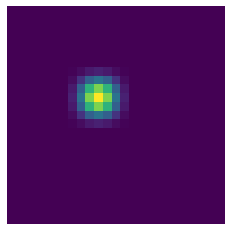

In [198]:
import torch
import torchvision.transforms
import random
labelf = torch.zeros(1,25,25)

len = 1
for i in range(-len,len+1):
    for j in range(-len,len+1):
        labelf[0][10+i][10+j] = 1
# print(labelf)
labelf_gussu = torchvision.transforms.GaussianBlur(kernel_size=(5, 5))(labelf)
print(labelf_gussu)
import matplotlib.pyplot as plt
import matplotlib
plt.imshow(labelf_gussu[0])
plt.xticks([])  # 去掉x轴
plt.yticks([])  # 去掉y轴
plt.axis('off')  # 去掉坐标轴
plt.savefig('1.png')
plt.show()
# X = [[0.1, 0.2, 0.3],
#      [0.4, 0.5, 0.6],
#      [0.7, 0.8, 0.9]]
# plt.imshow(X)
# plt.colorbar()
# plt.show()


In [14]:

import torch
import random
random.seed(0)

points = torch.randn((2,5,2))
# print(src_keypts)
batch_size = points.shape[0]
num_point = points.shape[1]
points_dist = torch.norm((points[:, :, None, :] - points[:, None, :, :]), dim=-1)

angel_k = 3
knn_indices = points_dist.topk(k=angel_k+1,dim=2,largest=False)[1][:,:,1:] # (B,N,k)  k+1 : get out the itself indice
# print(knn_indices)
knn_indices = knn_indices.unsqueeze(3).expand(batch_size,num_point,angel_k,2) # (B,N,K,2)
expanded_points = points.unsqueeze(1).expand(batch_size,num_point,num_point,2) # (B,N,K,2)
knn_points = torch.gather(expanded_points,dim=2,index=knn_indices) # (B,N,k,2)

ref_vectors = knn_points - points.unsqueeze(2)  # (B, N, k, 2)
anc_vectors = points.unsqueeze(1) - points.unsqueeze(2)  # (B, N, N, 2)
ref_vectors = ref_vectors.unsqueeze(2).expand(batch_size, num_point, num_point, angel_k, 2)  # (B, N, N, k, 2)
anc_vectors = anc_vectors.unsqueeze(3).expand(batch_size, num_point, num_point, angel_k, 2)  # (B, N, N, k, 2)
zeros = torch.zeros(batch_size, num_point, num_point, angel_k,1)
ref_vectors = torch.cat((ref_vectors,zeros),dim=-1)
anc_vectors = torch.cat((anc_vectors,zeros),dim=-1)
sin_values = torch.linalg.norm(torch.cross(ref_vectors, anc_vectors, dim=-1), dim=-1)  # (B, N, N, k)
cos_values = torch.sum(ref_vectors * anc_vectors, dim=-1)  # (B, N, N, k)
angles = torch.atan2(sin_values, cos_values)  # (B, N, N, k)
angle,_ = torch.max(angles,dim=-1)
print(angle)

# a_indices = angles * self.factor_a


tensor([[[0.0000, 2.0003, 2.0003, 1.9732, 1.2634],
         [1.0451, 0.0000, 0.7069, 0.8216, 1.0451],
         [3.0461, 2.6117, 0.0000, 3.0461, 2.1872],
         [0.5411, 0.4152, 0.6095, 0.0000, 0.6095],
         [1.5458, 2.3789, 2.3789, 2.7238, 0.0000]],

        [[0.0000, 2.1256, 1.2206, 2.1256, 2.1204],
         [3.1200, 0.0000, 1.6429, 2.6827, 3.1200],
         [0.8220, 1.0405, 0.0000, 1.2689, 1.2689],
         [1.4741, 0.8953, 1.4741, 0.0000, 0.8183],
         [1.4199, 1.4363, 1.4363, 1.0545, 0.0000]]])


In [82]:
import numpy as np
a= torch.randn(2)
b= torch.randn(2)
print(a,b)
# c = torch.cross(a, b, dim=-1)
d = np.cross(a,b)
print(a[0]*b[1]-a[1]*b[0])
print(d)

tensor([0.5631, 0.3623]) tensor([ 0.0236, -0.0448])
tensor(-0.0338)
-0.03377951


In [105]:
mask = torch.zeros(4,16)
mask[0][10] = 1
mask[0][4] = 1
mask[0][1] = 1
mask[0][9] = 1
mask[3][10] = 1
mask[2][10] = 1
mask[1][3] = 1
mask[1][4] = 1
mask[1][0] = 1
print(mask)

tensor([[0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


In [148]:

import torch.nn.functional as F
from kornia.geometry.subpix import dsnt
import math
import torchvision
import torch
from kornia.utils.grid import create_meshgrid
torch.manual_seed(0)
feat_f0,feat_f1 = torch.randn((4,225,64)),torch.randn((4,225,64))

# feat_f0 = feat_f1
M, WW, C = feat_f0.shape
W = int(math.sqrt(WW))
# b_ids,i_ids = torch.where(mask)
# feat_f0_picked = feat_f0[b_ids, i_ids, :]

sim_matrix = torch.einsum("nlc,nsc->nls", feat_f0, feat_f1)

softmax_temp = 1#1./C**0.5
heatmap = (F.softmax(sim_matrix*softmax_temp, 1) * F.softmax(sim_matrix*softmax_temp, 2)).view(M,WW,W,W) #[B,N,H,W]
heatmap_plot = heatmap[0][0]

# coords_normalized = dsnt.spatial_expectation2d(heatmap,True)
# print('coords_normalized:',coords_normalized)

# grid_normalized = create_meshgrid(W, W, True, heatmap.device).reshape(1,1, -1, 2)  # [1, WW, 2]
# print('grid_normalized',grid_normalized.shape)
# # compute std over <x, y>
# print(heatmap.shape)
# print(grid_normalized.shape) # [M,N,]
#
# cc = grid_normalized ** 2 * heatmap.view(M,WW, WW, 1)
# print('cc',cc.shape)
# cc = torch.sum(grid_normalized ** 2 * heatmap.view(M,WW, WW, 1), dim=2)
# print('cc',cc.shape)
#
# print(heatmap.shape)
# var = torch.sum(grid_normalized ** 2 * heatmap.view(M,WW, WW, 1), dim=2) - coords_normalized ** 2  # [M,N, 2]
# std = torch.sum(torch.sqrt(torch.clamp(var, min=1e-10)), -1)  # [M]  clamp needed for numerical stability
# print(var.shape)

# print(coords_normalized.shape)
# print(std.unsqueeze(-1).shape)
# print(coords_normalized.shape)


torch.Size([15, 15])


IndexError: tuple index out of range

In [7]:
import torch.nn.functional as F
from kornia.geometry.subpix import dsnt
import math
import torch
torch.manual_seed(0)
heatmaps = torch.randn(4,10,5,5)
# print(heatmaps)
t = dsnt.spatial_softmax2d(heatmaps)
coords_normalized = dsnt.spatial_expectation2d(t,True)
print(coords_normalized)
# torch.sum(coords_normalized)

tensor([[[ 2.5257e-01,  2.0074e-01],
         [-5.8142e-02,  5.7750e-02],
         [ 4.9692e-01, -1.4854e-01],
         [ 2.2080e-01,  3.6648e-02],
         [-2.3753e-02,  2.0779e-01],
         [ 8.5926e-02, -1.7117e-01],
         [ 7.4822e-03,  6.6056e-02],
         [-9.5009e-03,  6.3915e-02],
         [ 3.4156e-02, -3.9605e-02],
         [ 4.7725e-02, -4.1983e-02]],

        [[-1.7535e-01,  1.7920e-01],
         [ 6.0847e-02,  5.9953e-02],
         [ 4.5144e-02,  1.5138e-01],
         [ 1.2192e-01, -4.5469e-02],
         [-7.5722e-02, -2.1664e-01],
         [ 2.8752e-01,  3.6028e-01],
         [ 1.3572e-01, -1.0623e-02],
         [-1.0346e-01, -2.1705e-01],
         [-7.2428e-02, -5.1125e-01],
         [-8.2906e-02, -5.3942e-06]],

        [[-4.0005e-02,  2.1970e-01],
         [ 2.0428e-01, -5.4741e-03],
         [ 8.8297e-02,  1.6655e-02],
         [-1.2486e-01,  1.5341e-01],
         [-4.7809e-01, -1.6685e-01],
         [-1.0210e-01,  1.5660e-01],
         [-3.1013e-02, -2.7983e-01

/home/gzr/anaconda3/envs/loftr/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [212]:
heatmaps = torch.tensor([[[
[0.0, 0.3, 0.],
[0., 0.5, 0.1],
[0., 0., 0.1]]]])
print(torch.sum(heatmaps),'sum')
heatmaps = dsnt.spatial_softmax2d(heatmaps,temperature=torch.tensor(8))
print(heatmaps)
sum = torch.sum(heatmaps)
print(sum,'sum')
c = (dsnt.spatial_expectation2d(heatmaps, True)+1)*(5//2)
print(c)
dsnt.spatial_expectation2d(heatmaps, False)

tensor(1.) sum
tensor([[[[0.0133, 0.1468, 0.0133],
          [0.0133, 0.7273, 0.0296],
          [0.0133, 0.0133, 0.0296]]]])
tensor(1.0000) sum
tensor([[[2.0653, 1.7656]]])


tensor([[[1.0326, 0.8828]]])

In [118]:
sim_matrix = torch.tensor([[
[1., 1., 1.],
[1., 1, 1.],
[1., 1, 0.]]])
print(sim_matrix.shape)

heatmap = F.softmax(sim_matrix, 1) #* F.softmax(sim_matrix*softmax_temp, 2))#.view(M,WW,W,W) #[B,N,H,W]

print(heatmap)
heatmap =   F.softmax(F.softmax(sim_matrix, 2), 2) #.view(M,WW,W,W) #[B,N,H,W]
print(heatmap)
print(torch.sum(heatmap,dim=2)>0)

torch.Size([1, 3, 3])
tensor([[[0.3333, 0.3333, 0.4223],
         [0.3333, 0.3333, 0.4223],
         [0.3333, 0.3333, 0.1554]]])
tensor([[[0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333],
         [0.3616, 0.3616, 0.2769]]])
tensor([[True, True, True]])


In [135]:
W = 5
gridX = torch.arange(0, W).view(1, 1, -1).expand(1, W, W).contiguous().reshape(1, -1)
print(gridX)

tensor([[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
         4]])


In [17]:
c = torch.ones([2,2])
flow_map_mask = torch.zeros(5, 9,2)
# print(flow_map_mask)
list_1 = [0,0,3]
list_2 = [0,1,8]
data = torch.tensor([[1.0,1],[2,2],[3,3]])
flow_map_mask[list_1, list_2] = data
print(flow_map_mask)



tensor([[[1., 1.],
         [2., 2.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [3., 3.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])


/tmp/ipykernel_28846/3897286098.py:52: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mkpts0 = torch.stack((indices0 % w*scale+scale//2, indices0//w*scale+scale//2),dim=1)
/tmp/ipykernel_28846/3897286098.py:60: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mkpts1 = torch.stack((indices1 % w*scale+scale//2, indices1//w*scale+scale//2),d

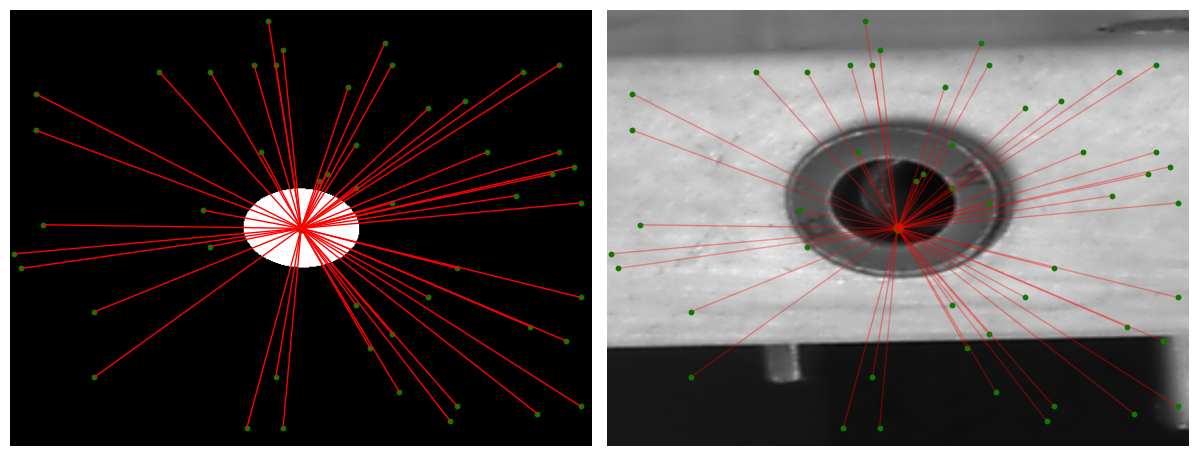

In [91]:
import torch
import numpy as np
import cv2
from matplotlib.collections import LineCollection
import bisect
import matplotlib.pyplot as plt
import matplotlib
torch.random.seed()
h,w = 60,80
scale = 8

img1_path = '/home/gzr/Data/hole_data/hole_dataset/0_hole/images/training/1.png'
img0_path = '/home/gzr/Data/hole_data/hole_dataset/0_hole/images/training/1_template.png'
img1 = cv2.imread(img1_path)
img0 = cv2.imread(img0_path)


def dynamic_alpha(conf,
                  milestones=[0,0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1],
                  alphas=[0,0.1,0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1]):
    if conf == 0:
        return 0
    ranges = list(zip(alphas, alphas[1:] + [None]))
    loc = bisect.bisect_right(milestones, conf) - 1
    _range = ranges[loc]
    if _range[1] is None:
        return _range[0]
    return _range[1] + (milestones[loc + 1] - conf) / (
            milestones[loc + 1] - milestones[loc]) * (_range[0] - _range[1])

def visualize_self_attention_map(att_mat_0, img0, att_mat_1, img1, rk, pos_0,pos_1):
    r"""

    :param att_mat: (L,S,h)
    :param img:
    :param rk:
    :return:
    """
    top_n = 50
    # 0. Average the attention weights across all heads.
    att_mat_0 = torch.mean(att_mat_0, dim=-1)
    att_mat_1 = torch.mean(att_mat_1, dim=-1)
    # 1. normalize the weights
    att_mat_0 = att_mat_0/att_mat_0.sum(dim=-1) # (L,S)
    att_mat_1 = att_mat_1/att_mat_1.sum(dim=-1) # (L,S)

    # center position
    pos0_flatten = pos_0[0]//scale + (pos_0[1]//scale) * w
    att_val_0 = att_mat_0[pos0_flatten]
    sorted, indices = torch.sort(att_val_0,descending=True)
    sorted0, indices0= sorted[0:top_n], indices[0:top_n]
    mkpts0 = torch.stack((indices0 % w*scale+scale//2, indices0//w*scale+scale//2),dim=1)
    sorted0 = np.array(sorted0)


    pos1_flatten = pos_1[0]//scale + (pos_1[1]//scale) * w
    att_val_1 = att_mat_0[pos1_flatten]
    sorted, indices = torch.sort(att_val_1,descending=True)
    sorted1, indices1= sorted[0:top_n], indices[0:top_n]
    mkpts1 = torch.stack((indices1 % w*scale+scale//2, indices1//w*scale+scale//2),dim=1)
    sorted1 = np.array(sorted1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=100)
    axes[0].imshow(img0, cmap='gray')
    axes[1].imshow(img1, cmap='gray')
    for i in range(2):  # clear all frames
        axes[i].get_yaxis().set_ticks([])
        axes[i].get_xaxis().set_ticks([])
        for spine in axes[i].spines.values():
            spine.set_visible(False)
    plt.tight_layout(pad=1)
    fig.canvas.draw()
    transFigure = fig.transFigure.inverted()


    fkpts0 = transFigure.transform(axes[0].transData.transform(mkpts0))
    fkpts1 = transFigure.transform(axes[1].transData.transform(mkpts1))
    fpos_0 = transFigure.transform(axes[0].transData.transform(pos_0))
    fpos_1 = transFigure.transform(axes[1].transData.transform(pos_1))

    fig.lines = [matplotlib.lines.Line2D((fpos_0[0], fkpts0[i, 0]),
                                         (fpos_0[1], fkpts0[i, 1]),zorder=1,
                                         transform=fig.transFigure,color=[1,0,0,1],  linewidth=1) #
                 for i in range(len(mkpts0))
                 ] + \
                [matplotlib.lines.Line2D((fpos_1[0], fkpts1[i, 0]),
                                         (fpos_1[1], fkpts1[i, 1]),
                                         transform=fig.transFigure,zorder=1,color=[1,0,0,dynamic_alpha(sorted1[i])*1000], linewidth=1)
                 for i in range(len(mkpts1))
                 ]

    axes[0].scatter(mkpts0[:, 0], mkpts0[:, 1], c='green', s=10,alpha=1)
    axes[1].scatter(mkpts1[:, 0], mkpts1[:, 1], c='green', s=10,alpha=1)
    #
    axes[0].scatter(pos_0[0], pos_0[1], c='green', s=40,alpha=1)
    axes[1].scatter(pos_1[0], pos_1[1], c='green', s=40,alpha=1)
    plt.show()

    plt.savefig('./'+str(rk)+'.png', bbox_inches='tight', pad_inches=0)
    plt.close()



att_mat_0 = torch.rand(h*w,h*w,4)
att_mat_1 = torch.rand(h*w,h*w,4)
visualize_self_attention_map(att_mat_0,img0,att_mat_1,img1,rk=1,pos_0=[320,240],pos_1=[320,240])


In [51]:
dynamic_alpha(0.55)

0.55

In [93]:
num_matches_pred = torch.tensor([2,100,1327,32])

num_to_padding = torch.clip(num_matches_pred*0.2, min=4, max=128).long()
print(num_to_padding)

tensor([  4,  20, 128,   6])


In [110]:
low = 1
high = 2
torch.randint(low,
                    high-1,
                    (10,))

RuntimeError: random_ expects 'from' to be less than 'to', but got from=1 >= to=1

In [120]:
theta = torch.tensor([1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=torch.float).view(1, 3, 3)
print(theta.shape)
theta_inv = torch.tensor([1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=torch.float).view(1, 3, 3).repeat(4, 1, 1)
trans = torch.tensor([1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=torch.float).view(1, 3, 3)
trans_inverse = trans.inverse()
print(theta[0].shape)
M = torch.einsum('bij,bjk->bik', theta[0].unsqueeze(0), trans_inverse)[0]

torch.Size([1, 3, 3])
torch.Size([3, 3])


In [5]:
import torch
patch_conf_matrix = torch.rand((256,25,25))
mask_3d = patch_conf_matrix > 0.0 # N,L,S
# 2. mutual nearest, and update the mask index
mask_3d = mask_3d * (patch_conf_matrix == patch_conf_matrix.max(dim=2, keepdim=True)[0]) \
       *(patch_conf_matrix == patch_conf_matrix.max(dim=1, keepdim=True)[0])
# this only works when at most one `True` in each row
mask, all_j_ids = mask_3d.max(dim=2)  # only select the positions in the template meeting the mutual nearest
# only select the positions in the template exsiting pixels
print(mask.shape)
b_ids_patch, i_ids_patch = torch.where(mask)
j_ids_patch = all_j_ids[b_ids_patch, i_ids_patch]  # [n]
mconf_patch = patch_conf_matrix[b_ids_patch, i_ids_patch, j_ids_patch]
print(b_ids_patch.shape)
print(b_ids_patch[0:100])

torch.Size([256, 25])
torch.Size([3317])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        8, 8, 8, 8])


In [115]:
import torch
map = torch.rand(3,32,6,8)
f_points = torch.rand(3,128,2).long()
print(map.shape)
W = 3
device = f_points.device
# out of bundary
# mask = (f_points[:,:,0]>=W//2) * (f_points[:,:,0]<w-W//2) *  (f_points[:,:,1]>=W//2) * (f_points[:,:,0]<w-W//2)
b_ids,i_ids = torch.where((f_points[:,:,0]>=0))  #[L]
gridX = torch.arange(-W//2+1, W//2+1).view(1, 1, -1).expand(1, W, W).contiguous().reshape(1, -1).to(
    device)  # (1,WW)
gridY = torch.arange(-W//2+1, W//2+1).view(1, -1, 1).expand(1, W, W).contiguous().reshape(1, -1).to(
    device)  # (1,WW)
y_ids = f_points[b_ids,i_ids,1][:,None] + gridY  #(L,W*W)
x_ids = f_points[b_ids,i_ids,0][:,None] + gridX  #(L,W*W)
print(y_ids.shape)
b_ids = b_ids[:,None].repeat(1,W*W)

print(b_ids.shape)
print(map.shape)
feat_f0_sample = map[b_ids,:,y_ids, x_ids]  # [L,W*W,C]
#
print(feat_f0_sample.shape)


torch.Size([3, 32, 6, 8])
torch.Size([384, 9])
torch.Size([384, 9])
torch.Size([3, 32, 6, 8])
torch.Size([384, 9, 32])


In [129]:
c = torch.rand(5,5)
print(c)
index = torch.tensor([[2,0,3],[1,2,3]])
print(index)
print(index.shape)
print(c[index, :].shape)


tensor([[0.5818, 0.7667, 0.4350, 0.6056, 0.1707],
        [0.8674, 0.0578, 0.7170, 0.8106, 0.5487],
        [0.8520, 0.8133, 0.6355, 0.9329, 0.1595],
        [0.2666, 0.4421, 0.6924, 0.7487, 0.6637],
        [0.3825, 0.9347, 0.1238, 0.7860, 0.3253]])
tensor([[2, 0, 3],
        [1, 2, 3]])
torch.Size([2, 3])
torch.Size([2, 3, 5])


In [19]:
import os
import cv2
import numpy as np
import random
import imgaug.augmenters as iaa
np.random.seed(66)
random.seed(66)

image_base_1 = '/home/gzr/Data/coco/raw_data/val_dataset/'
image_base_2 = '/home/gzr/Data/coco/raw_data/train_dataset/'
W, H = 640, 480


def get_range_random(min_=0.9, max_=1.1):
    return random.random() * (max_ - min_) + min_


def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def TwoPointRandInterP(p1,p2):
    v = (p2[0]-p1[0], p2[1]-p1[1])
    rr = random.random()
    v = (v[0]*rr, v[1]*rr)
    v = (int(v[0]+0.5), int(v[1]+0.5))
    return (p1[0]+v[0], p1[1]+v[1])


def positive_or_negative():
  if random.random() < 0.5:
    return 1
  else:
    return -1

def get_newpoint_between(p1, p2):
  v = (p2[0] - p1[0], p2[1] - p1[1])
  rr = random.random()
  v = (v[0] * rr, v[1] * rr)

  return ( round(p1[0]+positive_or_negative() * v[0]), round(p1[1]+ positive_or_negative() * v[1]))

def get_external_contours_points(image):
    """
    :param image: (H,W)
    :return: (N,2)
    """
    assert (len(image.shape) == 2)
    ret, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    xcnts = np.vstack([x.reshape(-1, 2) for x in contours])

    # gap = xcnts.shape[0] // num_point
    # xcnts = xcnts[:num_point * gap:gap, :]
    return xcnts

def RPTransform(w,h):
    ratio = 0.1
    c_c = ratio * w
    d_d = ratio * h

    A = (0,0)
    B = (0,h-1)
    C = (w-1,h-1)
    D = (w-1,0)

    a = (c_c,d_d)
    b = (c_c, h-1-d_d)
    c = (w-1-c_c, h-1-d_d)
    d = (w-1-c_c, d_d)

    At = get_newpoint_between(A, a)
    Bt = get_newpoint_between(B, b)
    Ct = get_newpoint_between(C, c)
    Dt = get_newpoint_between(D, d)

    Pts0 = np.array([(0, 0), (0, h), (w, h), (w, 0)]).astype('float32')
    Pts1 = np.array([At, Bt, Ct, Dt]).astype('float32')
    H = cv2.getPerspectiveTransform(Pts0, Pts1)
    return H

def warp_image_Homo(path,image, H=480, W=640):
    Homo = RPTransform(w=H, h=W)
    img = image # cv2.imread(path)

    img_homo = cv2.warpPerspective(img, Homo, (W, H))
    homo_path = path.replace('.png', '_homo.png')
    cv2.imwrite(homo_path, img_homo)

    path_trans = path.replace('images', 'trans')
    path_trans = path_trans.replace('.png', '_trans.npy')
    M = np.load(path_trans)
    Homo_M = np.matmul(Homo, M)
    Homo_M = Homo_M/Homo_M[2][2] # template -> img
    path_trans_homo = path_trans.replace('trans.npy', 'trans_homo.npy')
    np.save(path_trans_homo, Homo_M)
    return Homo_M

def get_external_contours_points_sample(image, num_point):
    """
    :param image: (H,W)
    :return: (N,2)
    """
    assert (len(image.shape) == 2)
    ret, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    xcnts = np.vstack([x.reshape(-1, 2) for x in contours])

    gap = xcnts.shape[0] // num_point
    xcnts = xcnts[:num_point * gap:gap, :]
    return xcnts

def save_data(image_save_dir, image, image_mask, cnt, resize=True):
    point_save_dir = image_save_dir.replace('images', 'points')
    trans_save_dir = image_save_dir.replace('images', 'trans')
    mkdir(image_save_dir)
    mkdir(point_save_dir)
    mkdir(trans_save_dir)

    # 2. resize data
    if resize:
        scale = [W / image.shape[1], H / image.shape[0]]  # x,y
        image_mask = cv2.resize(image_mask, dsize=(W, H))
        image = cv2.resize(image, dsize=(W, H))
        w, h = image_mask.shape[1], image_mask.shape[0]
    else:
        assert image[:,:,0].shape == image_mask.shape
        w, h = image_mask.shape[1], image_mask.shape[0]


    points = get_external_contours_points(image_mask)
    center = np.mean(points, axis=0)
    random_scale = get_range_random(min_=0.9, max_=1.1)
    random_angel = get_range_random(min_=-45, max_=45)
    M = cv2.getRotationMatrix2D(center, angle=random_angel, scale=random_scale)
    raw_add = np.array([0, 0, 1])
    M = np.r_[M, [raw_add]]
    translate = [w / 2 - center[0], h / 2 - center[1]]
    M[0, 2] += translate[0]
    M[1, 2] += translate[1]
    M_trans = np.linalg.inv(M)  #

    template = cv2.warpAffine(src=image_mask, M=M[0:2], dsize=(w, h))
    # cv2.imwrite(os.path.join(image_save_dir, str(cnt) + '.png'), image)
    cv2.imwrite(os.path.join(image_save_dir, str(cnt) + '_template.png'), template)
    np.save(os.path.join(trans_save_dir, str(cnt) + '_trans.npy'), M_trans)

    template_points = get_external_contours_points_sample(template, 20)
    np.save(os.path.join(point_save_dir, str(cnt) + '_template.npy'), template_points)
    warp_image_Homo(os.path.join(image_save_dir, str(cnt) + '.png'),image,H=image.shape[0],W = image.shape[1])

def deal_sample(path_mask, path_image, data_type, cnt):

    # raw_image
    image = cv2.imread(path_image)
    image_mask = cv2.imread(path_mask, 0)
    image_save_dir = '/home/gzr/Data/coco/coco_dataset/' + data_type + '/images/training/'
    save_data(image_save_dir, image, image_mask, cnt)



num_test = 50000
num_type= num_test//4
path_image_list = []
dir_images = image_base_2 + 'images/'
files = os.listdir(dir_images)
for file in files:
    path_image = os.path.join(dir_images, file)
    path_image_list.append(path_image)

print(len(path_image_list))
np.random.shuffle(path_image_list)
path_mask_list_test = path_image_list[0:num_test]
cnt = 0

for i in range(len(path_mask_list_test)):
    path_image = path_mask_list_test[i]
    path_mask = path_image.replace('/images', '/masks').replace('.jpg','.png')
    deal_sample(path_mask, path_image, str(cnt//num_type), cnt%num_type)
    cnt += 1

105020


ValueError: slice step cannot be zero

In [35]:
import numpy as np
import torch
court_poi = torch.tensor([[0,0],[640,0],[0,480],[640,480.0]]).unsqueeze(0).repeat(4,1,1)
# print(court_poi)
print(court_poi.shape)
import kornia
points_1 = court_poi  # BxNx3
trans_01 = torch.eye(3).view(1, 3, 3).repeat(4,1,1)  # Bx4x4
trans_01[0][0][0]=2
trans_01[0][1][1]=2
points_0 = kornia.geometry.linalg.transform_points(trans_01, points_1)  # BxNx3
print(points_0)

torch.Size([4, 4, 2])
tensor([[[   0.,    0.],
         [1280.,    0.],
         [   0.,  960.],
         [1280.,  960.]],

        [[   0.,    0.],
         [ 640.,    0.],
         [   0.,  480.],
         [ 640.,  480.]],

        [[   0.,    0.],
         [ 640.,    0.],
         [   0.,  480.],
         [ 640.,  480.]],

        [[   0.,    0.],
         [ 640.,    0.],
         [   0.,  480.],
         [ 640.,  480.]]])
